In [1]:
import pyhf
import json
import copy
import jsonpatch
import numpy as np
import matplotlib.pyplot as plt

## Download the Model

In [2]:
# !curl -sL https://doi.org/10.17182/hepdata.89408.v1/r2  | tar -O -xzv RegionA/BkgOnly.json > lhood.json
# !curl -sL https://doi.org/10.17182/hepdata.89408.v1/r2  | tar -O -xzv RegionA/patch.sbottom_750_745_60.json > patch.json

In [3]:
# spec = json.load(open("lhood.json"))
# patch = json.load(open("patch.json"))

In [4]:
test_spec = json.load(open("test.json"))
test_spec

{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'signal',
     'data': [1.0, 1.0],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None}]},
    {'name': 'bkg1',
     'data': [2.0, 8.0],
     'modifiers': [{'name': 'Modelling',
       'type': 'histosys',
       'data': {'hi_data': [5, 12], 'lo_data': [1, 6]}}]},
    {'name': 'bkg2',
     'data': [2.0, 19.0],
     'modifiers': [{'name': 'JES',
       'type': 'histosys',
       'data': {'hi_data': [4, 15], 'lo_data': [1, 8]}},
      {'name': 'JER',
       'type': 'histosys',
       'data': {'hi_data': [2, 15], 'lo_data': [1, 8]}}]},
    {'name': 'bkg3',
     'data': [1.0, 10.0],
     'modifiers': [{'name': 'JES2',
       'type': 'histosys',
       'data': {'hi_data': [4, 15], 'lo_data': [0.5, 14]}},
      {'name': 'JER2',
       'type': 'histosys',
       'data': {'hi_data': [2, 15], 'lo_data': [0.7, 18]}}]}]}],
 'observations': [{'name': 'singlechannel', 'data': [5.0, 28.0]}],
 'measurements': [{'name': 'M

## Helper Functions

In [5]:
def make_model(channel_list, measurement, spec, patch=None):
    if patch is not None:
        spec = jsonpatch.apply_patch(spec, patch)
    spec["channels"] = [
        channel for channel in spec["channels"] if channel["name"] in channel_list
    ]

    ws = pyhf.Workspace(spec)
    model = ws.model(
        #         measurement_name="NormalMeasurement",
        measurement_name=measurement,
        modifier_settings={
            "normsys": {"interpcode": "code4"},
            "histosys": {"interpcode": "code4p"},
        },
    )
    data = ws.data(model)
    return ws, model, data

In [6]:
_, _model, _data = make_model(["singlechannel"], "Measurement", test_spec)

In [7]:
# def fitresults(constraints=None):
def fitresults(model, data, constraints=None, verbose=False):
    #     _, model, data = make_model(["CRtt_meff"])

    pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=verbose))
    result = pyhf.infer.mle.fit(
        data, model, fixed_vals=constraints, return_uncertainties=True
    )
    bestfit = result[:, 0]
    errors = result[:, 1]
    return model, data, bestfit, errors

In [8]:
fitresults(_model, _data)

(<pyhf.pdf.Model at 0x7f917f6ca610>,
 [5.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 array([ 0.72656415, -0.03807308, -0.4725164 , -0.45550983,  0.03252481,
         0.04380875]),
 array([5.35464959, 0.99370223, 0.85454215, 0.88034681, 0.82409655,
        0.72807951]))

## Calculate per-parameter Impact

In [9]:
# def calc_impact(idx, bestfit, errors, i, width, poi_index):
def calc_impact(model, data, idx, bestfit, errors, width, poi_index):
    _, _, bb, ee = fitresults(model, data, [(idx, bestfit + errors)])
    poi_up_post = bb[poi_index]

    _, _, bb, ee = fitresults(model, data, [(idx, bestfit - errors)])
    poi_dn_post = bb[poi_index]

    _, _, bb, ee = fitresults(model, data, [(idx, bestfit + width)])
    poi_up_pre = bb[poi_index]

    _, _, bb, ee = fitresults(model, data, [(idx, bestfit - width)])
    poi_dn_pre = bb[poi_index]
    return np.asarray([poi_dn_post, poi_up_post, poi_dn_pre, poi_up_pre])

In [10]:
def get_impact_data(model, data):
    model, _, bestfit, errors = fitresults(model, data)
    widths = pyhf.tensorlib.concatenate(
        [
            model.config.param_set(k).width()
            for k, v in model.config.par_map.items()
            if model.config.param_set(k).constrained
        ]
    )
    initv = pyhf.tensorlib.concatenate(
        [
            model.config.param_set(k).suggested_init
            for k, v in model.config.par_map.items()
            if model.config.param_set(k).constrained
        ]
    )
    labels = np.asarray(
        [
            "{}[{:02}]".format(k, i)
            if model.config.param_set(k).n_parameters > 1
            else k
            for k in model.config.par_order
            if model.config.param_set(k).constrained
            for i in range(model.config.param_set(k).n_parameters)
        ]
    )
    poi_free = bestfit[model.config.poi_index]
    impacts = []

    for i, width in enumerate(widths):
        #### BUG FIX: REMOVE THIS CHECK
        #         if i == model.config.poi_index:
        #             continue
        if i % 5 == 0:
            print(i)
        #         impct = calc_impact(i, bestfit[i], errors[i], width, initv[i], model.config.poi_index) # not being used correctly
        impct = calc_impact(
            model, data, i, bestfit[i], errors[i], width, model.config.poi_index
        )
        impacts.append(impct - poi_free)
    return np.asarray(impacts), labels

In [11]:
impacts, labels = get_impact_data(_model, _data)

0


## Make the plot!

In [12]:
def plot_impact(impacts, labels, n_leading=None, xlim=None):
    # Order the nuisance paramters by ascending impact
    impact_order = np.argsort(np.max(np.abs(impacts[:, :2]), axis=1))
    impacts = impacts[impact_order]
    labels = labels[impact_order]

    if n_leading is not None:
        # Leading impact nuisance paramter is last in array
        impacts = impacts[-n_leading:]
        labels = labels[-n_leading:]

    fig, ax = plt.subplots()
    # Postfit -1 sigma impact???
    ax.barh(
        range(len(impacts)),
        np.asarray(impacts)[:, 0],
        alpha=0.75,
        linestyle="dashed",
        facecolor="red",
    )
    # Postfit +1 sigma impact???
    ax.barh(
        range(len(impacts)),
        np.asarray(impacts)[:, 1],
        alpha=0.75,
        linestyle="dashed",
        facecolor="blue",
    )
    # Prefit -1 sigma impact????
    ax.barh(
        range(len(impacts)),
        np.asarray(impacts)[:, 2],
        alpha=0.75,
        linestyle="dashed",
        fill=None,
        edgecolor="red",
    )
    # Prefit +1 sigma impact????
    ax.barh(
        range(len(impacts)),
        np.asarray(impacts)[:, 3],
        alpha=0.75,
        linestyle="dashed",
        fill=None,
        edgecolor="blue",
    )
    if xlim is None:
        max_impact = np.max(impacts[-1])
        max_impact = max_impact * 1.05
        xlim = (-max_impact, max_impact)
    ax.set_xlim(xlim)
    ax.set_ylim(-0.5, len(impacts) - 0.5)
    fig.set_size_inches(4, 17.5)
    ax.set_title("Δµ")
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels)
    ax.grid()

    return fig, ax

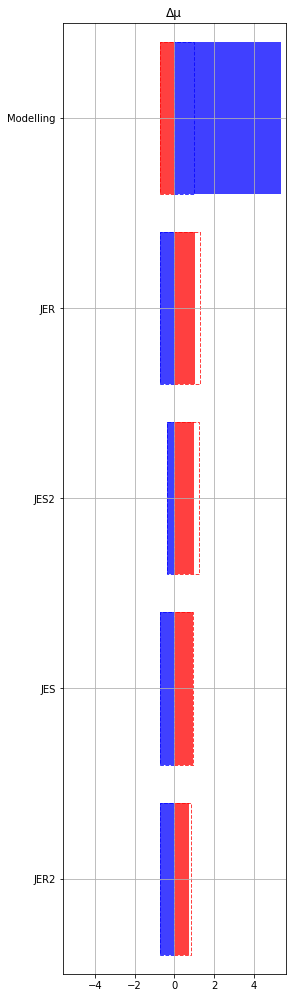

In [13]:
fig, ax = plot_impact(impacts, labels)

Alternative, the $n$ leading impact nuisance parameters can be selected

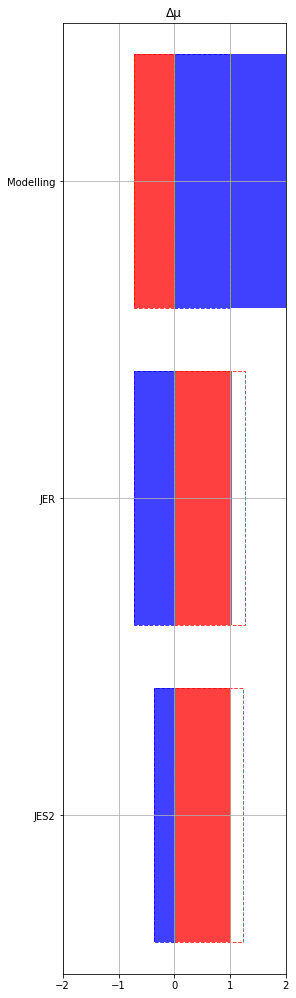

In [14]:
fig, ax = plot_impact(impacts, labels, n_leading=3, xlim=(-2, 2))